Yue write the code at 2023/07/23

The aim is to test the reponse curve of the motor to a step/sin input with the PID controller in the ODrive firmware itself. And tune the parameter to get a optimal performance in accuracy and response speed

All the speed/position/current PID controller is tuned.

## connection and calibration


In [2]:
import odrive
from odrive.enums import *
import time
import math
import matplotlib.pyplot as plt
from scipy.signal import butter,filtfilt
from IPython.display import clear_output

def check(my_drive):
    if my_drive.axis1.error == 0:
        print('Everything is fine')
    else:
        print('Error!')


def lowpass_filter(data,cutoff,fs,order):
    b,a=butter(order,2*cutoff/fs,btype='low',analog=False)
    y=filtfilt(b,a,data)
    return y 

In [3]:
# Find a connected ODrive (this will block until you connect one)
print("finding an odrive...")
my_drive = odrive.find_any()
print("Found! and the bus voltage is " + str(my_drive.vbus_voltage) + "V")



finding an odrive...
Found! and the bus voltage is 21.26228141784668V


In [4]:
# # calibration and enter closed control mode
# print("starting calibration...")
# my_drive.axis1.requested_state = AXIS_STATE_FULL_CALIBRATION_SEQUENCE
# while my_drive.axis1.current_state != AXIS_STATE_IDLE:
#     time.sleep(0.1)
# check(my_drive)
# my_drive.axis1.motor.config.pre_calibrated = True
# my_drive.axis1.encoder.config.pre_calibrated =True




my_drive.axis1.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
check(my_drive)

Everything is fine


In [5]:
print(my_drive.axis1.motor.current_control.i_gain)
my_drive.axis1.motor.current_control.i_gain = 2
print(my_drive.axis1.motor.current_control.i_gain)
print(my_drive.axis1.controller.config.vel_gain)
print(my_drive.axis1.controller.config.pos_gain)



82.6633529663086
2.0
8.0
20.0


## torque control


4.0
sample frequency is 408.75


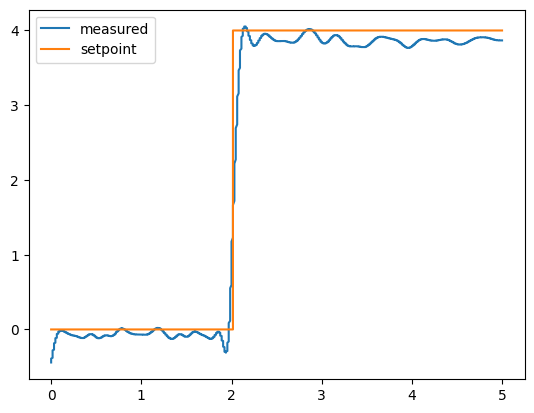

In [18]:
# step input with one gain
my_drive.axis1.controller.config.control_mode = 1
my_drive.axis1.motor.current_control.i_gain=4
my_drive.axis1.controller.input_torque = 0
t0=time.monotonic()
delta=0
current = []
id=[]
time_seq=[]
current_setpoint=[]

while delta<5:
    delta=time.monotonic()-t0
    time_seq.append(delta)
    current.append(my_drive.axis1.motor.current_control.Iq_measured)
    id.append(my_drive.axis1.motor.current_control.Id_measured)
    current_setpoint.append(my_drive.axis1.motor.current_control.Iq_setpoint)
    if delta>2:
        my_drive.axis1.controller.input_torque=4

my_drive.axis1.controller.input_torque = 0
fs=len(time_seq)/8
cutoff=3
print('sample frequency is',fs)
y = lowpass_filter(current,cutoff,fs,4)
y2=lowpass_filter(id,cutoff,fs,4)
    
plt.plot(time_seq,y,label='measured')
plt.plot(time_seq,current_setpoint,label='setpoint')
plt.legend()
plt.show()


In [ ]:
# step input with diffrent gains
my_drive.axis1.controller.config.control_mode = 1
current_dif_gain=[]
time_dif_gain=[]
Id_dif_gain=[]
dif_gain=[8,4,2,1,0.5]
for gain in dif_gain:
    my_drive.axis1.motor.current_control.i_gain=gain
    print(my_drive.axis1.motor.current_control.i_gain)
    t0=time.monotonic()
    delta=0
    current = []
    id=[]
    time_seq=[]
    current_setpoint=[]

    while delta<4:
        delta=time.monotonic()-t0
        # if delta>3 and delta<5:
        time_seq.append(delta)
        current.append(my_drive.axis1.motor.current_control.Iq_measured)
        id.append(my_drive.axis1.motor.current_control.Id_measured)
        # current_phB.append(my_drive.axis1.motor.current_meas_phB)
        # current_phC.append(my_drive.axis1.motor.current_meas_phC)
        current_setpoint.append(my_drive.axis1.motor.current_control.Iq_setpoint)
        # my_drive.axis1.controller.input_torque = delta*2
        if delta>2:
            my_drive.axis1.controller.input_torque=20
    
    my_drive.axis1.controller.input_torque = 0
    fs=len(time_seq)/8
    cutoff=3
    print('sample frequency is',fs)
    y = lowpass_filter(current,cutoff,fs,4)
    y2=lowpass_filter(id,cutoff,fs,4)
    current_dif_gain.append(y)
    Id_dif_gain.append(y2)
    time_dif_gain.append(time_seq)
    

# plt.plot(time_seq,current,label='measured')
# plt.plot(time_seq,current_setpoint,label='setpoint')
# plt.legend()
# plt.show()


In [ ]:

plt.plot(time_dif_gain[-1],current_setpoint,label='setpoint')
for i in range(len(dif_gain)):
    plt.plot(time_dif_gain[i],current_dif_gain[i],label='gain='+str(dif_gain[i]))
plt.legend()
plt.ylabel('current(A)')
plt.xlabel('time(s)')
plt.xlim([1,3])
plt.ylim([0,30])
plt.show()


In [ ]:
# sin input
my_drive.axis1.controller.config.control_mode = 1
current_dif_gain=[]
time_dif_gain=[]
Id_dif_gain=[]
dif_gain=[1,2,4]
f=0.5
for gain in dif_gain:
    my_drive.axis1.motor.current_control.i_gain=gain
    t0=time.monotonic()
    delta=0
    current = []
    id=[]
    time_seq=[]
    current_setpoint=[]

    while delta<2:
        delta=time.monotonic()-t0
        # if delta>3 and delta<5:
        time_seq.append(delta)
        current.append(my_drive.axis1.motor.current_control.Iq_measured)
        id.append(my_drive.axis1.motor.current_control.Id_measured)
        # current_phB.append(my_drive.axis1.motor.current_meas_phB)
        # current_phC.append(my_drive.axis1.motor.current_meas_phC)
        current_setpoint.append(my_drive.axis1.motor.current_control.Iq_setpoint)
        # my_drive.axis1.controller.input_torque = delta*2
        setpoint = 5 * math.sin(delta*2*math.pi*f)
        print("goto " + str(setpoint))
        my_drive.axis1.controller.input_torque = setpoint
            
    my_drive.axis1.controller.input_torque = 0
    fs=len(time_seq)/8
    cutoff=3
    print('sample frequency is',fs)
    y = lowpass_filter(current,cutoff,fs,4)
    y2=lowpass_filter(id,cutoff,fs,4)
    current_dif_gain.append(y)
    Id_dif_gain.append(y2)
    time_dif_gain.append(time_seq)
    

# plt.plot(time_seq,current,label='measured')
# plt.plot(time_seq,current_setpoint,label='setpoint')
# plt.legend()
# plt.show()


In [ ]:

plt.plot(time_dif_gain[-1],current_setpoint,label='setpoint')
for i in range(len(dif_gain)):
    plt.plot(time_dif_gain[i],current_dif_gain[i],label='gain='+str(dif_gain[i]))
plt.legend()
plt.ylabel('current(A)')
plt.xlabel('time(s)')
plt.xlim([0,1.5])
# plt.ylim([3,6])
plt.show()

plt.plot(time_seq,lowpass_filter(current_phB,cutoff,fs,4),label='phB_filtered')
plt.plot(time_seq,lowpass_filter(current_phC,cutoff,fs,4),label='phC_filtered')
plt.plot(time_seq,current_phB,label='phB')
plt.plot(time_seq,current_phC,label='phC')
plt.legend()
plt.show()

In [ ]:
my_drive.save_configuration()
check(my_drive)

## velocity control


In [ ]:
# modify configuration here
# my_drive.axis1.controller.config.control_mode = 3
# my_drive.axis1.controller.config.vel_gain = 3
print(my_drive.axis1.controller)

find zero point
t0=time.monotonic()
delta = 0
while delta<80:
    delta=time.monotonic()-t0
    if int(delta*100)%10==0:
        print(my_drive.axis1.encoder.shadow_count )


In [ ]:
# veciloty control with different gains
my_drive.axis1.controller.config.control_mode = 2



time_dif_gain=[]
vel_dif_gain=[]
set_dif_gain=[]
dif_gain=[0.5,1,2,4,8]
for gain in dif_gain:
    my_drive.axis1.controller.config.vel_gain = gain
    # print(my_drive.axis1.controller.config)
    t0=time.monotonic()
    delta=0
    pos_seq = [0]
    time_seq=[0]
    vel_seq=[0]
    pos_setpoint=[0]
    vel_setpoint=[0]
    cpr=16384

    while delta<3:
        delta=time.monotonic()-t0
        time_seq.append(delta)
        pos_seq.append(my_drive.axis1.encoder.pos_circular)#range (0,1) - in turn
        pos_setpoint.append(my_drive.axis1.controller.pos_setpoint)
        vel_seq.append(my_drive.axis1.encoder.vel_estimate )#unit is turns/s
        vel_setpoint.append(my_drive.axis1.controller.vel_setpoint)

        if delta>2:
            my_drive.axis1.controller.input_vel=0.01

    my_drive.axis1.controller.input_vel = 0
    time_dif_gain.append(time_seq)
    vel_dif_gain.append(vel_seq)
    set_dif_gain.append(vel_setpoint)



In [ ]:
plt.plot(time_dif_gain[-1],set_dif_gain[-1],label='setpoint')
for i in range(len(dif_gain)):
    plt.plot(time_dif_gain[i],vel_dif_gain[i],label='gain='+str(dif_gain[i]))
plt.legend()
plt.ylabel('velocity(turns/s)')
plt.xlabel('time(s)')
plt.xlim([1,3])
plt.ylim([0,5])
plt.show()

In [ ]:
# veciloty control with one gain
my_drive.axis1.controller.config.control_mode = 1

time_dif_gain=[]
vel_dif_gain=[]
set_dif_gain=[]
gain=10

my_drive.axis1.controller.config.vel_gain = gain
# print(my_drive.axis1.controller.config)
t0=time.monotonic()
delta=0
pos_seq = [0]
time_seq=[0]
vel_seq=[0]
pos_setpoint=[0]
vel_setpoint=[0]
cpr=16384

while delta<3:
    delta=time.monotonic()-t0
    time_seq.append(delta)
    pos_seq.append(my_drive.axis1.encoder.pos_circular)#range (0,1) - in turn
    pos_setpoint.append(my_drive.axis1.controller.pos_setpoint)
    vel_seq.append(my_drive.axis1.encoder.vel_estimate )#unit is turns/s
    vel_setpoint.append(my_drive.axis1.controller.vel_setpoint)

    # if delta>2:
    #     my_drive.axis1.controller.input_vel=0.1

my_drive.axis1.controller.input_vel = 0
time_dif_gain.append(time_seq)
vel_dif_gain.append(vel_seq)
set_dif_gain.append(vel_setpoint)





In [ ]:
# plt.plot(time_seq,vel_seq)
# plt.plot(time_seq,vel_setpoint)
plt.plot(time_seq[100:-1],pos_seq[100:-1])

plt.show()

In [ ]:


check(my_drive)

In [ ]:
# my_drive.save_configuration()
check(my_drive)
# my_drive.axis1.clear_errors()
# check(my_drive)

## position control


In [ ]:
# position control
my_drive.axis1.controller.config.control_mode = 3
check(my_drive)

In [ ]:
my_drive.axis1.controller.input_pos=1.2
print(my_drive.axis1.controller.pos_setpoint)
print(my_drive.axis1.encoder.pos_circular)


In [ ]:
# step input
time_dif_gain=[]
pos_dif_gain=[]
set_dif_gain=[]
dif_pos_gain=[10,15,20,25]
FREQUENCY=0.2
for gain in dif_pos_gain:

    pos_gain = gain
    my_drive.axis1.controller.config.pos_gain = pos_gain
    my_drive.axis1.controller.input_pos = 0.5
    time.sleep(2)


    # print(my_drive.axis1.controller.config)
    t0=time.monotonic()
    delta=0
    pos_seq = [0]
    time_seq=[0]
    vel_seq=[0]
    pos_setpoint=[0]
    vel_setpoint=[0]
    cpr=16384


    while delta<8:
        delta=time.monotonic()-t0
        time_seq.append(delta)
        pos_seq.append(my_drive.axis1.encoder.pos_circular)#range (0,1) - in turn
        pos_setpoint.append(my_drive.axis1.controller.pos_setpoint)
        # vel_seq.append(my_drive.axis1.encoder.vel_estimate )#unit is turns/s
        # vel_setpoint.append(my_drive.axis1.controller.vel_setpoint)

        #step input
        # if delta>4:
        #     my_drive.axis1.controller.input_pos=0.5
        #     print('STEP INPUR of 180 degree position with gain={}'.format(gain))

        #sin input
        if int(delta*10000)%10==0:
            pos=0.3*math.sin(delta*2*math.pi*FREQUENCY)+0.5
            my_drive.axis1.controller.input_pos=pos
            clear_output()
            print('POSITION INPUT {} degree \nGAIN={}'.format(pos*180/math.pi,gain))

        


    time_dif_gain.append(time_seq)
    pos_dif_gain.append(pos_seq)
    set_dif_gain.append(pos_setpoint)

plt.plot(time_dif_gain[-1],set_dif_gain[-1],label='setpoint')
plt.plot(time_dif_gain[-1],pos_dif_gain[-1],label='gain='+str(pos_gain))
plt.legend()
plt.ylabel('pos(percentage of a whole circle)')
plt.xlabel('time(s)')
# plt.xlim([1,3])
# plt.ylim([0,5])
plt.show()

check(my_drive)


In [ ]:
plt.plot(time_dif_gain[-1],set_dif_gain[-1],label='setpoint')
for i in range(len(dif_pos_gain)):
    plt.plot(time_dif_gain[i],pos_dif_gain[i],label='gain='+str(dif_pos_gain[i]))
plt.legend()
plt.ylabel('pos(turns)')
plt.xlabel('time(s)')
plt.xlim([3,5])
# plt.ylim([0,1])
plt.show()


check(my_drive)

In [ ]:
my_drive.axis1.controller.config.pos_gain = 20
my_drive.save_configuration()